In [11]:
import cv2
import numpy as np
import os
import pandas as pd
import csv

from sklearn.cluster import MiniBatchKMeans
from sklearn.neural_network import MLPClassifier
from progressbar import ProgressBar


In [3]:
sift = cv2.SIFT_create()

In [7]:
img_path = '../TargetImages/'
train = pd.read_csv('TargetData-TF-Train.csv')
landmarks = train['landmark_id'].sort_values().unique()

dico = []


for leaf in train.id:
    img = cv2.imread(img_path + str(leaf) + ".jpg")
    kp, des = sift.detectAndCompute(img, None)

    for d in des:
        dico.append(d)

#### Length of the initial sift is 128

In [8]:
len(dico[0])

128

In [9]:

k = np.size(landmarks) * 10

batch_size = np.size(os.listdir(img_path)) * 3
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, verbose=1).fit(dico)

Init 1/3 with method k-means++
Inertia for init 1/3: 55282762340.0
Init 2/3 with method k-means++
Inertia for init 2/3: 54471035853.0
Init 3/3 with method k-means++
Inertia for init 3/3: 54113601395.0
Minibatch step 1/398: mean batch inertia: 131989.31600810314
Minibatch step 2/398: mean batch inertia: 90239.63389100766, ewa inertia: 90239.63389100766
Minibatch step 3/398: mean batch inertia: 89202.67939124984, ewa inertia: 89718.56917069212
Minibatch step 4/398: mean batch inertia: 88596.99153137438, ewa inertia: 89154.98172391432
Minibatch step 5/398: mean batch inertia: 88397.02686697399, ewa inertia: 88774.11300148178
Minibatch step 6/398: mean batch inertia: 88319.0401898174, ewa inertia: 88545.44107095012
Minibatch step 7/398: mean batch inertia: 87959.7182441848, ewa inertia: 88251.11812719301
Minibatch step 8/398: mean batch inertia: 87924.49384706283, ewa inertia: 88086.99097483093
Minibatch step 9/398: mean batch inertia: 87823.38207194227, ewa inertia: 87954.52875080041
Mini

In [12]:

kmeans.verbose = False

histo_list = []
pbar = ProgressBar()
for leaf in pbar(train.id):
    img = cv2.imread(img_path + str(leaf) + ".jpg")
    kp, des = sift.detectAndCompute(img, None)

    histo = np.zeros(k)
    nkp = np.size(kp)

    for d in des:
        idx = kmeans.predict([d])
        histo[idx] += 1/nkp # Because we need normalized histograms, I prefere to add 1/nkp directly

    histo_list.append(histo)

100% |########################################################################|


In [ ]:
histo_list[0]

In [19]:
X = np.array(histo_list)
Y = np.array(train['landmark_id'])

In [25]:
mlp = MLPClassifier(verbose=True, max_iter=600000)
mlp.fit(X, Y)

Iteration 1, loss = 1.62740358
Iteration 2, loss = 1.62303321
Iteration 3, loss = 1.61996034
Iteration 4, loss = 1.61716372
Iteration 5, loss = 1.61442112
Iteration 6, loss = 1.61206139
Iteration 7, loss = 1.60961020
Iteration 8, loss = 1.60764445
Iteration 9, loss = 1.60565657
Iteration 10, loss = 1.60390325
Iteration 11, loss = 1.60210342
Iteration 12, loss = 1.60073147
Iteration 13, loss = 1.59909878
Iteration 14, loss = 1.59804296
Iteration 15, loss = 1.59677473
Iteration 16, loss = 1.59578671
Iteration 17, loss = 1.59473923
Iteration 18, loss = 1.59375170
Iteration 19, loss = 1.59290252
Iteration 20, loss = 1.59195527
Iteration 21, loss = 1.59095879
Iteration 22, loss = 1.58982755
Iteration 23, loss = 1.58888476
Iteration 24, loss = 1.58778661
Iteration 25, loss = 1.58685528
Iteration 26, loss = 1.58570440
Iteration 27, loss = 1.58476394
Iteration 28, loss = 1.58369812
Iteration 29, loss = 1.58293715
Iteration 30, loss = 1.58180893
Iteration 31, loss = 1.58094512
Iteration 32, los

MLPClassifier(max_iter=600000, verbose=True)

In [41]:
test = pd.read_csv('TargetData-TF-Test.csv')

result_file = open("sift.csv", "w")
result_file_obj = csv.writer(result_file)
result_file_obj.writerow(np.append("id", landmarks))
pbars = ProgressBar()
predictionsarr = []

for leaf in pbars(test.id):
    img = cv2.imread(img_path + str(leaf) + ".jpg")
    kp, des = sift.detectAndCompute(img, None)

    x = np.zeros(k)
    nkp = np.size(kp)

    for d in des:
        idx = kmeans.predict([d])
        x[idx] += 1/nkp

    res = mlp.predict_proba([x])
    row = []
    row.append(leaf)
    predictionsarr.append(mlp.predict([x]))
    for e in res[0]:
        row.append(e)

    result_file_obj.writerow(row)

result_file.close()

100% |########################################################################|


In [51]:
predictions = np.array(predictionsarr)

finpreds = []
for i in range(len(predictions)):
    finpreds.append(predictions[i][0])

In [53]:
labels_test = np.array(test['landmark_id'])
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(finpreds, labels_test)

In [54]:
accuracy

0.648

In [55]:
from sklearn.metrics import confusion_matrix
confusion_matrix(labels_test, finpreds)

array([[17,  2,  2,  2,  2],
       [ 2, 16,  3,  2,  2],
       [ 2,  3, 16,  1,  3],
       [ 1,  1,  0, 18,  5],
       [ 3,  1,  2,  5, 14]])

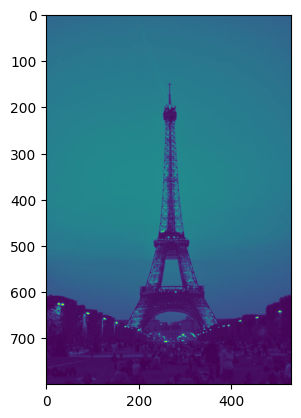

In [58]:
import matplotlib.pyplot as plt
im = cv2.imread('../TargetImages/201edb4a52549725.jpg', 0)
imgplot = plt.imshow(im)
